### Data load

+ `__getitem__`：返回一条数据，或一个样本。`obj[index]`等价于`obj.__getitem__(index)`
+ `__len__`：返回样本的数量。len(obj)等价于`obj.__len__()`

In [1]:
!tree --charset ASCII ./data/dogcat/

./data/dogcat/
|-- cat.12484.jpg
|-- cat.12485.jpg
|-- cat.12486.jpg
|-- cat.12487.jpg
|-- dog.12496.jpg
|-- dog.12497.jpg
|-- dog.12498.jpg
`-- dog.12499.jpg

0 directories, 8 files


In [2]:
import torch
from torch.utils import data

In [3]:
import os
from PIL import Image
import numpy as np

class DogCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        # 1 dog, 0 cat
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        np_img = np.asarray(pil_img)
        data = torch.from_numpy(np_img)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

In [4]:
datasets = DogCat('./data/dogcat')
img, label = datasets[0]  # datasets.__getitem__(0)
for img, label in datasets:
    print(img.shape, img.float().mean(), label)

torch.Size([375, 499, 3]) tensor(150.5079) 1
torch.Size([500, 497, 3]) tensor(106.4915) 0
torch.Size([499, 379, 3]) tensor(171.8085) 0
torch.Size([375, 499, 3]) tensor(116.8138) 1
torch.Size([374, 499, 3]) tensor(115.5177) 0
torch.Size([236, 289, 3]) tensor(130.3004) 0
torch.Size([377, 499, 3]) tensor(151.7174) 1
torch.Size([400, 300, 3]) tensor(128.1550) 1


`torchvision.transforms`对`PIL Image`和`Tensor`对象提供常用的操作:

对PIL Image的操作包括：

+ Scale：调整图片尺寸，长宽比保持不变
+ CenterCrop、RandomCrop、RandomResizedCrop： 裁剪图片
+ Pad：填充
+ ToTensor：将PIL Image对象转成Tensor，会自动将[0, 255]归一化至[0, 1]

对Tensor的操作包括：
+ Normalize：标准化，即减均值，除以标准差
+ ToPILImage：将Tensor转为PIL Image对象

In [5]:
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose([
    transforms.Resize(224), # 缩放，保持最短边为224
    transforms.CenterCrop(224), # 剪裁中间224*224区域
    transforms.ToTensor(), 
    transforms.Normalize(mean=[.5, .5, .5],
                        std=[.5, .5, .5]) 
    # 标准化至[-1, 1],规定各个通道上的均值和方差
])

class DogCat(data.Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        # 1 dog, 0 cat
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return len(self.imgs)
    
datasets = DogCat('./data/dogcat', transforms=transform)
img, label = datasets[0]
for img, label in datasets:
    print(img.size(), img.float().mean(), label)

torch.Size([3, 224, 224]) tensor(0.1176) 1
torch.Size([3, 224, 224]) tensor(-0.1654) 0
torch.Size([3, 224, 224]) tensor(0.3892) 0
torch.Size([3, 224, 224]) tensor(-0.0649) 1
torch.Size([3, 224, 224]) tensor(-0.0462) 0
torch.Size([3, 224, 224]) tensor(0.0711) 0
torch.Size([3, 224, 224]) tensor(0.2234) 1
torch.Size([3, 224, 224]) tensor(-0.0267) 1


`torchvision`已经预先实现了常用的Dataset，包括前面使用过的CIFAR-10，以及ImageNet、COCO、MNIST、LSUN等数据集，可通过诸如`torchvision.datasets.CIFAR10`来调用.`ImageFolder`假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名，其构造函数如下：
`ImageFolder(root, transform=None, target_transform=None, loader=default_loader)`
+ target_transform：对label的转换
+ loader：给定路径后如何读取图片，默认读取为RGB格式的PIL Image对象


In [7]:
!tree --charset ASCII  ./data/dogcat_2/

./data/dogcat_2/
|-- cat
|   |-- cat.12484.jpg
|   |-- cat.12485.jpg
|   |-- cat.12486.jpg
|   `-- cat.12487.jpg
`-- dog
    |-- dog.12496.jpg
    |-- dog.12497.jpg
    |-- dog.12498.jpg
    `-- dog.12499.jpg

2 directories, 8 files


In [8]:
from torchvision.datasets import ImageFolder
datasets = ImageFolder('./data/dogcat_2')

In [9]:
datasets.class_to_idx

{'cat': 0, 'dog': 1}

In [10]:
datasets.imgs

[('./data/dogcat_2/cat/cat.12484.jpg', 0),
 ('./data/dogcat_2/cat/cat.12485.jpg', 0),
 ('./data/dogcat_2/cat/cat.12486.jpg', 0),
 ('./data/dogcat_2/cat/cat.12487.jpg', 0),
 ('./data/dogcat_2/dog/dog.12496.jpg', 1),
 ('./data/dogcat_2/dog/dog.12497.jpg', 1),
 ('./data/dogcat_2/dog/dog.12498.jpg', 1),
 ('./data/dogcat_2/dog/dog.12499.jpg', 1)]

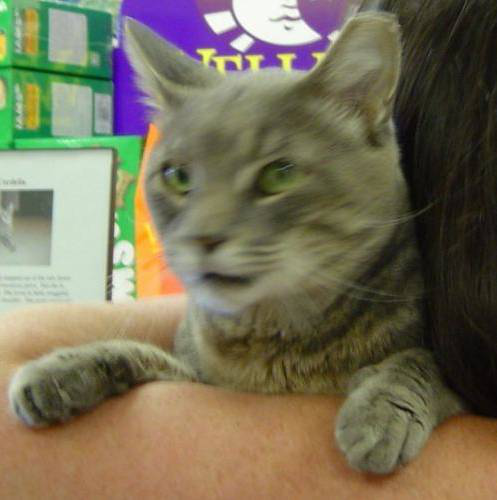

In [11]:
datasets[0][0]

In [12]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.4, .4, .4],
                        std=[.2, .2, .2])
])

datasets = ImageFolder('./data/dogcat_2/', transform=transform)

In [13]:
datasets.__getitem__(0)[0].shape
# datasets.[0][1].shape

torch.Size([3, 224, 224])

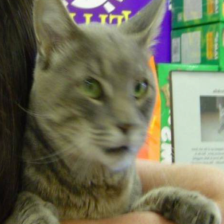

In [14]:
to_pil = transforms.ToPILImage()
to_pil(datasets[0][0] * 0.2 + 0.4)

Dataset只负责数据的抽象，一次调用`__getitem__`只返回一个样本。DataLoader的函数定义如下： DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=default_collate, pin_memory=False, drop_last=False)

+ dataset：加载的数据集(Dataset对象)
+ batch_size：batch size
+ shuffle:：是否将数据打乱
+ sampler： 样本抽样，后续会详细介绍
+ num_workers：使用多进程加载的进程数，0代表不使用多进程 
+ collate_fn： 如何将多个样本数据拼接成一个batch，一般使用默认的拼接方式即可
+ pin_memory：是否将数据保存在pin memory区，pin memory中的数据转到GPU会快一些
+ drop_last：dataset中的数据个数可能不是batch_size的整数倍，drop_last为True会将多出来不足一个batch的数据丢弃


In [15]:
dataloader = torch.utils.data.DataLoader(datasets,
                    batch_size=3, shuffle=True, 
                    num_workers=0, drop_last=True)

In [16]:
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.size() # batch_size, channel, height, width

torch.Size([3, 3, 224, 224])

In [17]:
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(), batch_labels.size())

torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([3, 3, 224, 224]) torch.Size([3])


### 图片损坏
在`__getitem__`函数中将出现异常，此时最好的解决方案即是将出错的样本剔除。也可以返回None对象，然后在Dataloader中实现自定义的`collate_fn`，将空对象过滤掉。在这种情况下dataloader返回的batch数目会少于batch_size。

In [18]:
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            return None, None
        
from torch.utils.data.dataloader import default_collate

def my_collect_fn(batch):
    # batch (data, label)
    batch = list(filter(lambda x: x[0] is not None, batch))
    if len(batch)==0:
        return torch.Tensor()
    return default_collate(batch)

In [19]:
datasets = NewDogCat('./data/dogcat_wrong//', transforms=transform)

In [20]:
len(datasets)

9

In [21]:
dataloader = torch.utils.data.DataLoader(datasets, 2, collate_fn=my_collect_fn, 
                                         num_workers=1,shuffle=True,
                                        drop_last=True)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(),batch_labels.size())

torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])


`WeightedRandomSampler`时需提供两个参数：
+ 每个样本的权重weights,权重越大的样本被选中的概率越大，待选取的样本数目一般小于全部的样本数目。
+ 共选取的样本总数num_samples，
+ 以及一个可选参数replacement,指定是否可以重复选取某一个样本，默认为True

replacement用于指定是否可以重复选取某一个样本，默认为True，即允许在一个epoch中重复采样某一个数据。如果设为False，则当某一类的样本被全部选取完，但其样本数目仍未达到num_samples时，sampler将不会再从该类中选择数据，此时可能导致weights参数失效

In [22]:
datasets = DogCat('./data/dogcat/', transforms=transform)

weights = [2 if label == 1 else 1 for data, label in datasets]
weights

[2, 1, 1, 2, 1, 1, 2, 2]

In [23]:
from torch.utils.data.sampler import WeightedRandomSampler

sampler = WeightedRandomSampler(weights, num_samples=9, replacement=True)
dataloader = torch.utils.data.DataLoader(datasets, batch_size=3,
                                        sampler=sampler)
for data, labels in dataloader:
    print(labels.tolist())

[1, 1, 0]
[0, 0, 1]
[1, 0, 0]


In [24]:
sampler = WeightedRandomSampler(weights, num_samples=8, replacement=False)
dataloader = torch.utils.data.DataLoader(datasets, batch_size=4,
                                        sampler=sampler)
for data, labels in dataloader:
    print(labels.tolist())

[1, 1, 0, 1]
[0, 0, 1, 0]


### torchvision

In [39]:
from torchvision import models
from torch import nn

# ~/.torch/models/
resnet34 = models.squeezenet1_1(pretrained=True, num_classes=1000)

resnet34.fc = nn.Linear(512, 10)

In [40]:
# from torchvision import datasets
import torchvision
datasets = torchvision.datasets.MNIST('../data/', download=False, train=False,
                        transform=transform)

Transforms中涵盖了大部分对Tensor和PIL Image的常用处理。需要注意的是转换分为两步，
+ 第一步：构建转换操作，例如transf = transforms.Normalize(mean=x, std=y)，
+ 第二步：执行转换操作，例如output = transf(input)。

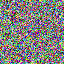

In [30]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
to_pil(torch.randn(3, 64, 64))

In [31]:
len(datasets)

10000

torchvision还提供了两个常用的函数。
+ `make_grid`，它能将多张图片拼接成一个网格中；
+ `save_img`，它能将Tensor保存成图片。

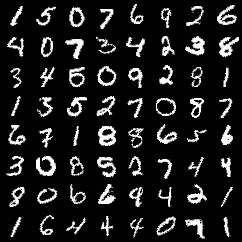

In [48]:
transform1 = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5])])

datasets = torchvision.datasets.MNIST('../data/', download=False, train=False,
                        transform=transform1)

dataloader = torch.utils.data.DataLoader(datasets, shuffle=True,
                                        batch_size=64)
from torchvision.utils import make_grid, save_image
dataiter = iter(dataloader)
imgs = torchvision.utils.make_grid(next(dataiter)[0], 8)
to_pil(imgs)

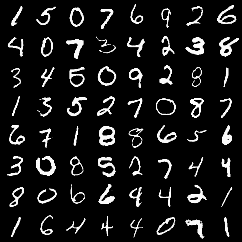

In [49]:
save_image(imgs, 'a.png')
Image.open('a.png')

In [50]:
!ls -l a.png

-rw-r--r--  1 liufang  staff  13417  4 14 10:59 a.png


### Tensorboard

In [7]:
!tensorboard --logdir ./experiment_cnn/ --port 6006

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [2]:
from tensorboardX import SummaryWriter

In [5]:
# log_dir 指定文件的保存路径
# flush_secs用来同步刷新间隔
logger = SummaryWriter(log_dir='experiment_cnn', flush_secs=2)

In [6]:
for i in range(100):
    logger.add_scalar('data/loss', 10 - i ** 0.5)
    logger.add_scalar('data/accuracy', i ** 0.5 / 10)

左侧的Horizontal Axis下有三个选项，分别是：

+ Step：根据步长来记录，log_value时如果有步长，则将其作为x轴坐标描点画线。
+ Relative：用前后相对顺序描点画线，可认为logger自己维护了一个step属性，每调用一次log_value就自动加１。
+ Wall：按时间排序描点画线。

### Visdom
+ env：环境。不同环境的可视化结果相互隔离，互不影响，在使用时如果不指定env，默认使用main。不同用户、不同程序一般使用不同的env。
+ pane：窗格。窗格可用于可视化图像、数值或打印文本等，其可以拖动、缩放、保存和关闭。一个程序中可使用同一个env中的不同pane，每个pane可视化或记录某一信息。

注意：
+ 需手动指定保存env，可在web界面点击save按钮或在程序中调用save方法，否则visdom服务重启后，env等信息会丢失。
+ 客户端与服务器之间的交互采用tornado异步框架，可视化操作不会阻塞当前程序，网络异常也不会导致程序退出。

Visdom同时支持PyTorch的tensor和Numpy的ndarray两种数据结构，但不支持Python的int、float等类型，

In [8]:
# 启动visdom服务器
# nohup python -m visdom.server &
# https://blog.csdn.net/qq_32523711/article/details/103345741

In [14]:
import torch

In [17]:
import visdom

# 新建一个客服端
# port=8097, host='localhost'
vis = visdom.Visdom(env=u'test1', use_incoming_socket=False)

x = torch.arange(1, 30, 0.01)
y = torch.sin(x)
vis.line(X=x, Y=y, win='sinx', opts={'title': 'y=sin(x)'})

Setting up a new session...
Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


'sinx'

+ win：用于指定pane的名字，如果不指定，visdom将自动分配一个新的pane。如果两次操作指定的win名字一样，新的操作将覆盖当前pane的内容，因此建议每次操作都重新指定win。
+ opts：选项，接收一个字典，常见的option包括title、xlabel、ylabel、width等，主要用于设置pane的显示格式。

之前提到过，每次操作都会覆盖之前的数值，但往往我们在训练网络的过程中需不断更新数值，如损失值等，这时就需要指定参数`update='append'`来避免覆盖之前的数值。

In [19]:
for i in range(0, 10):
    x = torch.Tensor([i])
    y = x
    vis.line(X=x, Y=y, win='polynomial', update='append' 
             if i > 0 else None)
    
x = torch.arange(0, 9, 0.1)
y = (x ** 2) / 9
vis.line(X=x, Y=y, win='polynomial', 
        name='this is a new Trace', update='new')

'polynomial'

In [21]:
vis.image(torch.randn(64, 64).numpy())
vis.image(torch.randn(3, 64, 64).numpy(), win='random1')
vis.images(torch.randn(36, 3, 64, 64).numpy(),
          nrow=6, win='random3', 
           opts={'title': 'random_image'})

'random3'

In [22]:
vis.text(u'''<h1>Hello Visdom</h1><br>Visdom是Facebook专门为<b>PyTorch</b>开发的一个可视化工具，
         在内部使用了很久，在2017年3月份开源了它。
         
         Visdom十分轻量级，但是却有十分强大的功能，支持几乎所有的科学运算可视化任务''',
         win='visdom_html',
         opts={'title': u'visdom简介' }
        )

'visdom_html'

In [23]:
torch.set_default_tensor_type('torch.FloatTensor')

from torchvision.models import SqueezeNet
model = SqueezeNet()
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.squeeze.weight', 'features.3.squeeze.bias', 'features.3.expand1x1.weight', 'features.3.expand1x1.bias', 'features.3.expand3x3.weight', 'features.3.expand3x3.bias', 'features.4.squeeze.weight', 'features.4.squeeze.bias', 'features.4.expand1x1.weight', 'features.4.expand1x1.bias', 'features.4.expand3x3.weight', 'features.4.expand3x3.bias', 'features.5.squeeze.weight', 'features.5.squeeze.bias', 'features.5.expand1x1.weight', 'features.5.expand1x1.bias', 'features.5.expand3x3.weight', 'features.5.expand3x3.bias', 'features.7.squeeze.weight', 'features.7.squeeze.bias', 'features.7.expand1x1.weight', 'features.7.expand1x1.bias', 'features.7.expand3x3.weight', 'features.7.expand3x3.bias', 'features.8.squeeze.weight', 'features.8.squeeze.bias', 'features.8.expand1x1.weight', 'features.8.expand1x1.bias', 'features.8.expand3x3.weight', 'features.8.expand3x3.bias', 'features.9.squeeze.weight', 'features.9.squeeze.bias', 'features.9.

In [24]:
torch.save(model.state_dict(), 'squeezenet.pth')
model.load_state_dict(torch.load('squeezenet.pth'))

<All keys matched successfully>

In [25]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.1)

In [26]:
torch.save(optimizer.state_dict(), 'optimizer.pth')
optimizer.load_state_dict(torch.load('optimizer.pth'))

In [27]:
all_data = dict(
    optimizer = optimizer.state_dict(),
    model = model.state_dict(),
    info = 'all paramters'
)
torch.save(all_data, 'all.pth')

In [28]:
all_data = torch.load('all.pth')
all_data.keys()

dict_keys(['optimizer', 'model', 'info'])

In [29]:
!ls -l 

total 20704
-rw-r--r--@ 1 liufang  staff    13417  4 14 10:59 a.png
-rw-r--r--  1 liufang  staff  5005171  4 14 16:12 all.pth
drwxr-xr-x  6 liufang  staff      192  4 14 09:15 data
drwxr-xr-x  4 liufang  staff      128  4 14 11:15 experiment_cnn
-rw-r--r--  1 liufang  staff      682  4 14 16:08 optimizer.pth
-rw-r--r--  1 liufang  staff  5004514  4 14 16:04 squeezenet.pth
-rw-r--r--@ 1 liufang  staff   566555  4 14 16:15 tools.ipynb
